In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../Code/')
from testWN import testWN as twm
from surrogate_model_training_data import get_data

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [104]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
from surrogate_model_training_data import get_data

# Get network informations

In [106]:
inp_file = '../Code/c-town_true_network_simplified_controls.inp'
ctown = twm(inp_file)
nw_node_df = pd.DataFrame(ctown.wn.nodes.todict())
nw_link_df = pd.DataFrame(ctown.wn.links.todict())

node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

# Data Pre-Processing

Get clusters:

In [107]:
cluster_labels = pd.read_json('cluster_labels_dt1h.json')
pressure_factor = pd.read_json('pressure_factor_dt1h.json')
n_clusters = 30

# Create Training Data:

In [108]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_1hourSampling/'
file_list = os.listdir(data_path)[:3]
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]

n_arx = 0
nn_input, nn_output = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False)

In [137]:
#filter_1 = (nn_output<0).any(axis=1)
filter_2 = (nn_input<0).any(axis=1)
nn_input.loc[filter_2]

type    sys_states                                                        \
name    tank_press                                                         
index           T3        T1        T7            T6        T5        T2   
21600     4.425601  2.880739  4.999999  5.499999e+00  4.500002  4.109958   
25200     4.895796  2.409628  4.999999  5.499999e+00  4.500002  3.831761   
28800     5.309678  1.831301  4.999999  5.499999e+00  4.500002  3.489210   
32400     6.257927  1.137789  4.999999  5.499999e+00  4.500002  2.724638   
36000     6.749999  0.453278  4.999999  5.499999e+00  4.500002  2.113764   
...            ...       ...       ...           ...       ...       ...   
2538000   6.749999  6.500002 -0.000003  1.146907e+00  4.500002  5.899998   
2541600   6.749999  6.500002 -0.000003  8.246287e-01  4.500002  5.899998   
2545200   6.749999  6.500002 -0.000003  9.291992e-05  4.500002  5.899998   
2548800   6.749999  6.500002 -0.000003  9.291992e-05  4.500002  5.899998   
2556000   6.749999  6.500002 -0.000003 -9.765625e-08  4.500002  5.899998   

type                   sys_inputs                      ...                    \
name              head_pump_speed                      ... jun_cl_demand_sum   
index          T4             PU2       PU5       PU6  ...                20   
21600   -0.000004         0.00000  0.919856  0.668056  ...          0.001902   
25200   -0.000004         0.00000  0.919856  0.668056  ...          0.003912   
28800   -0.000004         0.00000  1.291780  0.817179  ...          0.005222   
32400   -0.000004         0.00000  1.291780  0.817179  ...          0.005164   
36000   -0.000004         0.00000  1.291780  0.817179  ...          0.003474   
...           ...             ...       ...       ...  ...               ...   
2538000  4.699997         1.94319  1.721720  1.996590  ...          0.003718   
2541600  4.699997         1.94319  1.721720  1.996590  ...          0.006986   
2545200  4.699997         1.94319  1.721720  1.996590  ...          0.003778   
2548800  4.699997         1.94319  1.721720  1.996590  ...          0.003584   
2556000  4.699997         1.94319  1.721720  1.996590  ...          0.002219   

type                                                                      \
name                                                                       
index     21        22        23        24        25        26        27   
21600    0.0  0.002229  0.003971  0.000346  0.000523  0.000236  0.000330   
25200    0.0  0.004585  0.002928  0.000711  0.001075  0.000485  0.000678   
28800    0.0  0.006120  0.005198  0.000949  0.001436  0.000647  0.000906   
32400    0.0  0.006051  0.003654  0.000938  0.001419  0.000640  0.000895   
36000    0.0  0.004071  0.003476  0.000631  0.000955  0.000431  0.000602   
...      ...       ...       ...       ...       ...       ...       ...   
2538000  0.0  0.004357  0.005095  0.000676  0.001022  0.000461  0.000645   
2541600  0.0  0.008187  0.005912  0.001269  0.001920  0.000866  0.001211   
2545200  0.0  0.004427  0.007751  0.000686  0.001039  0.000468  0.000655   
2548800  0.0  0.004200  0.002801  0.000651  0.000985  0.000444  0.000621   
2556000  0.0  0.002600  0.004497  0.000403  0.000610  0.000275  0.000385   

type                         
name                         
index          28        29  
21600    0.002126  0.000632  
25200    0.001568  0.000581  
28800    0.002783  0.000540  
32400    0.001957  0.000803  
36000    0.001861  0.000840  
...           ...       ...  
2538000  0.002728  0.001280  
2541600  0.003166  0.001632  
2545200  0.004150  0.001270  
2548800  0.001500  0.000955  
2556000  0.002408  0.000960  

[1236 rows x 46 columns]

### Normalize Data:

In [54]:
input_offset = 0*nn_input.mean()
nn_input_offset = nn_input - input_offset

input_scaling = nn_input_offset.abs().max()
input_scaling.loc[input_scaling.abs()<1e-5]=1e-5
nn_input_scaled = nn_input_offset/input_scaling

output_offset = 0*nn_output.mean()
nn_output_offset = nn_output - output_offset

output_scaling = nn_output_offset.abs().max()
output_scaling.loc[output_scaling.abs()<1e-5]=1e-5
nn_output_scaled = nn_output_offset/output_scaling

### Train / Test Splitting

In [55]:
X_train, X_test, Y_train, Y_test = train_test_split(nn_input_scaled, nn_output_scaled, test_size=0.2)

In [56]:
X_train.shape

(80640, 46)

# Neural Network

## Create Model

In [60]:
n_layer = 4
n_units = 80
l1_regularizer = 0

model_param = {}
model_param['n_in'] = nn_input.shape[1]
model_param['n_out'] = nn_output.shape[1]
model_param['n_units'] = (n_layer)*[n_units]
model_param['activation'] = (n_layer) * ['tanh']

inputs = keras.Input(shape=(model_param['n_in'],))

layer_list = [inputs]


for i in range(len(model_param['n_units'])-1):
    layer_list.append(
        keras.layers.Dense(model_param['n_units'][i],
                           activation=model_param['activation'][i],
                           kernel_regularizer=keras.regularizers.l1(l=l1_regularizer)
                           )(layer_list[i])
    )

outputs = keras.layers.Dense(model_param['n_out'],
                             activation='linear')(layer_list[-1])

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 46)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 80)                3760      
_________________________________________________________________
dense_5 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_6 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_7 (Dense)              (None, 42)                3402      
Total params: 20,122
Trainable params: 20,122
Non-trainable params: 0
_________________________________________________________________


## Train model

In [61]:
optim = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-8, patience=50, mode='min')
model.compile(optimizer=optim,
              loss='mse')

In [95]:
history = model.fit(X_train.to_numpy(), 
                    Y_train.to_numpy(), 
                    batch_size=8064, 
                    epochs=500,
                    validation_data=(X_test.to_numpy(),Y_test.to_numpy()),
                    callbacks=[callback])

Train on 80640 samples, validate on 20160 samples
Epoch 1/500
80640/80640 [==============================] - 0s 6us/sample - loss: 5.6316e-04 - val_loss: 5.9397e-04
Epoch 2/500
80640/80640 [==============================] - 1s 8us/sample - loss: 6.3833e-04 - val_loss: 5.3840e-04
Epoch 3/500
80640/80640 [==============================] - 0s 5us/sample - loss: 5.4489e-04 - val_loss: 5.4554e-04
Epoch 4/500
80640/80640 [==============================] - 1s 6us/sample - loss: 5.3979e-04 - val_loss: 5.3569e-04
Epoch 5/500
80640/80640 [==============================] - 0s 6us/sample - loss: 5.4374e-04 - val_loss: 5.4758e-04
Epoch 6/500
80640/80640 [==============================] - 0s 6us/sample - loss: 5.4639e-04 - val_loss: 5.5006e-04
Epoch 7/500
80640/80640 [==============================] - 0s 5us/sample - loss: 5.9205e-04 - val_loss: 5.3735e-04
Epoch 8/500
80640/80640 [==============================] - 0s 5us/sample - loss: 5.5586e-04 - val_loss: 5.8502e-04
Epoch 9/500
80640/80640 [=====

80640/80640 [==============================] - 0s 5us/sample - loss: 5.2311e-04 - val_loss: 5.2806e-04
Epoch 142/500
80640/80640 [==============================] - 0s 6us/sample - loss: 5.2538e-04 - val_loss: 5.1914e-04
Epoch 143/500
80640/80640 [==============================] - 1s 8us/sample - loss: 5.7584e-04 - val_loss: 5.1347e-04
Epoch 144/500
80640/80640 [==============================] - 0s 5us/sample - loss: 5.3613e-04 - val_loss: 5.4779e-04
Epoch 145/500
80640/80640 [==============================] - 0s 6us/sample - loss: 5.3445e-04 - val_loss: 5.1548e-04
Epoch 146/500
80640/80640 [==============================] - 0s 5us/sample - loss: 5.2556e-04 - val_loss: 5.8608e-04
Epoch 147/500
80640/80640 [==============================] - 0s 6us/sample - loss: 6.0794e-04 - val_loss: 6.6114e-04
Epoch 148/500
80640/80640 [==============================] - 0s 5us/sample - loss: 5.6183e-04 - val_loss: 5.2164e-04
Epoch 149/500
80640/80640 [==============================] - 0s 6us/sample - l

80640/80640 [==============================] - 0s 4us/sample - loss: 5.0697e-04 - val_loss: 4.9947e-04
Epoch 282/500
80640/80640 [==============================] - 0s 4us/sample - loss: 5.0631e-04 - val_loss: 5.2082e-04
Epoch 283/500
80640/80640 [==============================] - 0s 5us/sample - loss: 5.1939e-04 - val_loss: 5.1261e-04
Epoch 284/500
80640/80640 [==============================] - 0s 5us/sample - loss: 5.2060e-04 - val_loss: 5.2727e-04
Epoch 285/500
80640/80640 [==============================] - 0s 5us/sample - loss: 5.2163e-04 - val_loss: 5.2254e-04
Epoch 286/500
80640/80640 [==============================] - 0s 5us/sample - loss: 5.3928e-04 - val_loss: 4.9564e-04
Epoch 287/500
80640/80640 [==============================] - 0s 5us/sample - loss: 5.1332e-04 - val_loss: 5.0200e-04
Epoch 288/500
80640/80640 [==============================] - 0s 5us/sample - loss: 5.0329e-04 - val_loss: 5.0601e-04
Epoch 289/500
80640/80640 [==============================] - 0s 5us/sample - l

In [102]:
model_path = './models/'
model_name = '002_mam_4x80'
model.save(model_path+model_name)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/002_mam_4x80/assets


# Validation

In [96]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_1hourSampling/Validation/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]

n_arx = 0
nn_input_val_list, nn_output_val_list = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False, return_lists=True)

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



In [97]:
class simulator:
    def __init__(self, model, input_scaling, output_scaling, input_offset, output_offset, x0, t0):
        self.model = model
        
        self.input_scaling = input_scaling.to_numpy().reshape(1,-1)
        self.output_scaling = output_scaling.to_numpy().reshape(1,-1)
        self.input_offset = input_offset.to_numpy().reshape(1,-1)
        self.output_offset = output_offset.to_numpy().reshape(1,-1)
        
        self.x = x0
        self.n_x = x0.shape[1]
        self.aux = []
                
        self.t = np.array([t0]).reshape(-1,1)
        self.dt = 3600
            
    def eval_nn(self):
        # Scale input:
        self.nn_in = np.concatenate((self.x[[-1],:], self.u[[-1],:]),axis=1).reshape(1,-1)
        self.nn_in_scaled = (self.nn_in-self.input_offset)/self.input_scaling
        # Evaluate NN:
        self.nn_out_scaled = self.model.predict(self.nn_in_scaled)
        # Scale output:
        self.nn_out = self.nn_out_scaled*self.output_scaling+self.output_offset
#         x_new = self.nn_out[:,:self.n_x]
        x_new = self.x[[-1],:]+self.nn_out[:,:self.n_x]
        aux_new = self.nn_out[:,self.n_x:]
        self.aux.append(aux_new)
    
        self.x = np.append(self.x, x_new, axis=0)
        self.t = np.append(self.t, np.copy(self.t)[[-1]]+self.dt, axis=0)
        
        
    def next_step(self, sys_inputs_now):
        if 'u' in self.__dict__:
            self.u = np.append(self.u, sys_inputs_now.reshape(1,-1), axis=0)
        else:
            self.u = sys_inputs_now.reshape(1,-1)
        
        self.eval_nn()

In [98]:
val_i = 3

sys_states = nn_input_val_list[val_i]['sys_states']
sys_inputs = nn_input_val_list[val_i]['sys_inputs']
sys_aux_outputs = nn_output_val_list[val_i]['aux_outputs']

x0 = sys_states.head(1).to_numpy()
t0 = 0

nsim = simulator(model, input_scaling, output_scaling, input_offset, output_offset, x0, t0)

In [99]:
for k in range(100):
    print(k)
    sys_inputs_now = sys_inputs.iloc[k].to_numpy()
    nsim.next_step(sys_inputs_now)
sim_res = pd.DataFrame(nsim.x, columns=sys_states.columns, index=nsim.t.flatten())
sim_aux = pd.DataFrame(np.concatenate(nsim.aux), columns = sys_aux_outputs.columns,index=nsim.t.flatten()[:-1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


<IPython.core.display.Javascript object>


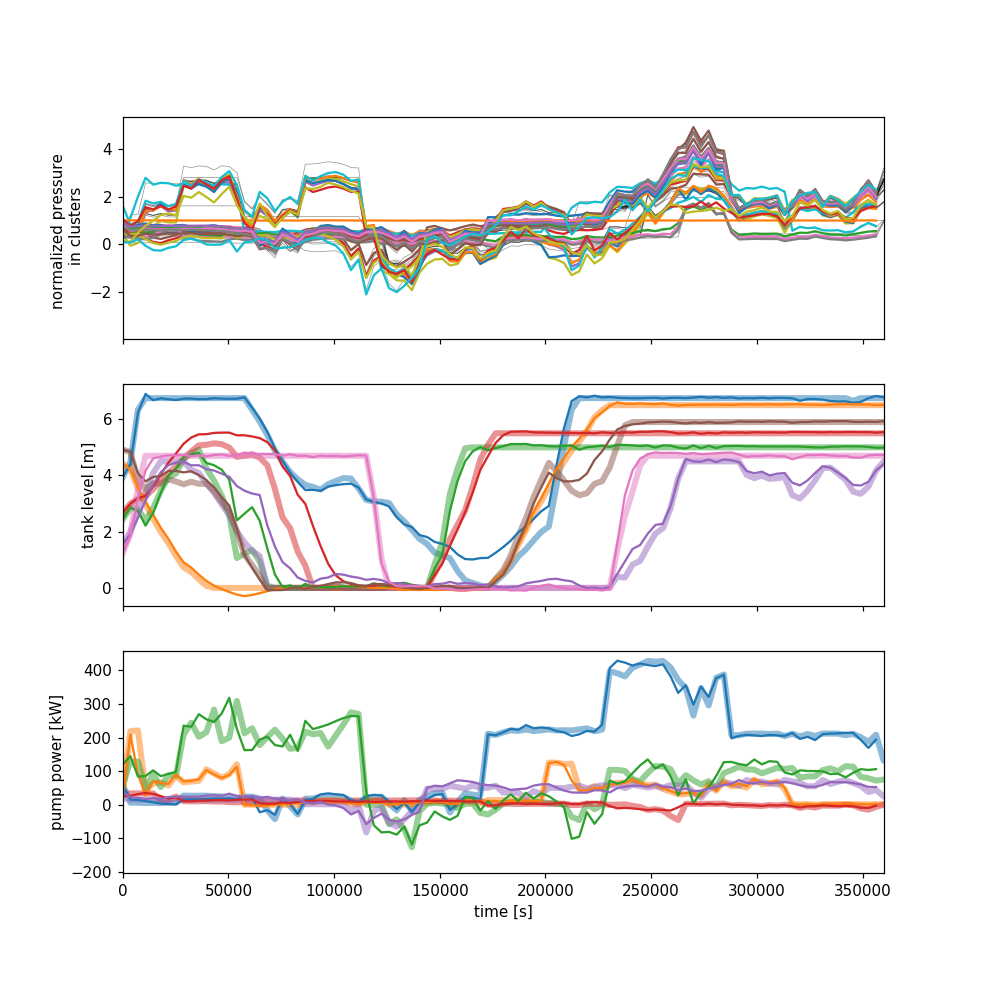

Text(0.5, 0, 'time [s]')

In [100]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(9,9))

sys_aux_outputs['jun_cl_press_mean'].plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_aux['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

sys_states['tank_press'].plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res['tank_press'].plot(ax=ax[1], legend=False)

sys_aux_outputs['pump_energy'].plot(ax=ax[2], legend=False, alpha=0.5, linewidth=4)
ax[2].set_prop_cycle(None)
sim_aux['pump_energy'].plot(ax=ax[2], legend=False)

ax[0].set_xlim(0, sim_res.index.max())
ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[2].set_ylabel('pump power [kW]')
ax[2].set_xlabel('time [s]')